In [1]:
"""Loading and initial visualization"""
from typing import List, Tuple, Dict

import pandas as pd
import numpy as np
from numpy.fft import fft
from scipy.signal import welch
import matplotlib.pyplot as plt

DEFAULT_COLUMNS = ['AF7', 'AF8', 'TP9', 'TP10']
SPICY_FILE = '../data/Alex-data/05202021-Alex-SpicyDuringRecording.csv'
BASELINE_FILE = '../data/Alex-data/05202021-Alex-Baseline-eyesopen.csv'

## Methods

In [2]:
def load_data(path: str, col_prefix: str = '') -> Tuple[pd.DataFrame, float]:
    """Load csv with EEG data"""
    d = pd.read_csv(path)
    ts = np.array(d['timestamps'])
    freq = 1 / (ts[1:] - ts[:-1]).mean() # Calculate frequency from timestamps in csv
    data = d[[col_prefix + col for col in DEFAULT_COLUMNS]] # Table of channel columns
    return data, freq

In [3]:
def eeg_to_waves(eeg: np.ndarray, fs: float):
    """Create PSD and split it into convenient bands
    :param eeg: 2D array or dataframe with one channel raw eeg (N x channels)
    :param fs: frequency
    :return Dict like {<band name> : (<frequency array>, <power array>)}
    """
    f, p = welch(eeg, fs)
    p = p[f < 60]
    f = f[f < 60]
    di = np.where(f > 4)[0][0]
    ti = np.where(f > 7)[0][0]
    ai = np.where(f > 13)[0][0]
    bi = np.where(f > 30)[0][0]
    return {
        'delta': (f[:di], p[:di]),
        'theta': (f[di - 1:ti], p[di - 1:ti]),
        'alpha': (f[ti - 1:ai], p[ti - 1:ai]),
        'beta': (f[ai - 1:bi], p[ai - 1:bi]),
        'gamma': (f[bi - 1:], p[bi - 1:]),
        'total': (f, p)
    }


def plot_wave_pds(waves: Dict[str, Tuple[np.ndarray, ...]], prefix='',
                  show=True, only_total=False, ax=None):
    """Plot PSD from one channel
    :param waves: Output of eeg_to_waves
    :param prefix: Prefix to label of each band in legend
    :param show: Show Figure after this method
    :param only_total: Instead of showing every bands separately shows one PSD plot
    :param ax: Matplotlib axis to use for plotting
    """
    if only_total:
        keys = ['total']
    else:
        keys = [k for k in waves.keys() if k != 'total']
    plotter = plt if ax is None else ax
    for k in keys:
        plotter.plot(*waves[k], label=f'{prefix} {k}')
        plotter.fill_between(*waves[k], np.zeros(len(waves[k][0])), alpha=0.5)
    plt.yscale('log')
    if show:
        plt.legend()
        plt.show()

In [4]:
def data_eeg_to_waves(data: pd.DataFrame, fs: float):
    """Applies eeg_to_waves to each channel
    :param data: raw eeg data
    :param fs: frequency
    :return Dict like {<channel name> : <output of eeg_to_waves>}
    """
    return {k: eeg_to_waves(data[k], fs) for k in data.keys()}



def plot_all_channels(data, tag: str, show: bool = True,
                      only_total: bool = False):
    """Plot all channels on subplots
    :param data: Output of data_eeg_to_waves
    :param tag: Tag to label relevant plots
    :param show: Show figure after this method
    :param only_total: Show only total PSD without split into signal bands
    """
    fig = plt.gcf()
    axes = fig.get_axes()
    for i, c in enumerate(data.keys()):
        if len(axes) == 0:
            ax = plt.subplot(2, 2, i + 1)
            ax.set_title(c)
            ax.set_ylabel('log power')
            ax.set_xlabel('freq (Hz)')
        else:
            ax = axes[i]
        plot_wave_pds(data[c], tag, show=False, only_total=only_total, ax=ax)
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
    if show:
        plt.gcf().legend(handles, labels, loc='upper right')
        plt.gcf().suptitle('PSD Plot')
        plt.show()

In [5]:
def time_psd(data: pd.DataFrame, freq: float, step: float, length: float):
    """Create PSD on time windows
    :param data: RAW eeg
    :param freq: frequency
    :param step: Step of a time window in seconds
    :param length: Length of a time window in seconds
    :return Dict like {<channel name> : {<eeg band> : <2d array with PSD values and shape like time x frequency>}}
    """
    step = int(step * freq)
    length = int(length * freq)
    w = []
    res = {}
    for i in range(0, len(data), step):
        t_data = data[i:i + length]
        w.append(data_eeg_to_waves(t_data, freq))
    for k in w[0].keys():
        res[k] = {}
        for kk in w[0][k].keys():
            res[k][kk] = (w[0][k][kk][0], np.stack([ww[k][kk][1] for ww in w]))
    return res


def plot_time_psd(t_psd, title=None):
    """Plot 2D maps of time changes
    :param t_psd: output of time_psd
    :param title: Plot title
    """
    axes = plt.gcf().get_axes()
    for i, c in enumerate(t_psd.keys()):
        ax = plt.subplot(2, 2, i + 1)
        ax.set_title(c)
        to_show = np.log(t_psd[c]['total'][1])
        to_show -= to_show.mean(0)
        ax.imshow(to_show, cmap='coolwarm')
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
    if title is not None:
        plt.gcf().suptitle(title)
    plt.show()

In [6]:
def calc_power_band(waves: Dict[str, Tuple[np.ndarray, ...]]):
    """Calculate power band of waves"""
    pb = {}
    for k in waves:
        f, p = waves[k]
        pb[k] = np.sum(p, -1) / (f[-1] - f[0])
    return pb

def plot_channel_powershift(t_psd, tag: str, show=True):
    """Plot power within each time window
    :param t_psd: Output o time_psd
    :param tag: Tag to label plot in legend
    :param show: Show figure after this method
    """
    axes = plt.gcf().get_axes()
    for i, c in enumerate(t_psd.keys()):
        if len(axes) == 0:
            ax = plt.subplot(2, 2, i + 1)
            ax.set_title(c)
            ax.set_ylabel('log power')
            ax.set_xlabel('time (s)')
            ax.set_yscale('log')
        else:
            ax = axes[i]
        power = calc_power_band(t_psd[c])['total']
        ax.plot(power, label=tag)
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
    if show:
        plt.gcf().legend(handles, labels, loc='upper right')
        plt.gcf().suptitle('Channel Powershift')
        plt.show()

## Example

### Load data and show example plot

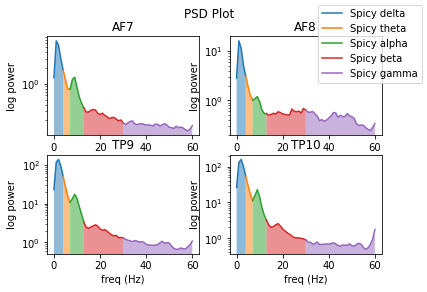

In [7]:
data_spicy, freq_spicy = load_data(SPICY_FILE)
data_base, freq_base = load_data(BASELINE_FILE)
s_waves = data_eeg_to_waves(data_spicy, freq_spicy)
b_waves = data_eeg_to_waves(data_base, freq_base)

plot_all_channels(s_waves, 'Spicy')

### Show PSD for comparison

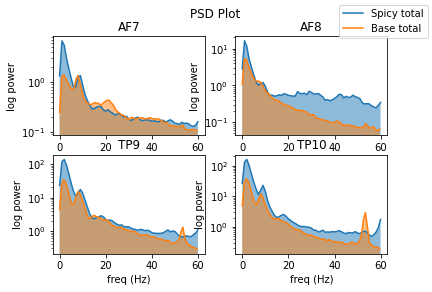

In [8]:
plot_all_channels(s_waves, 'Spicy', False, True)
plot_all_channels(b_waves, 'Base', only_total=True)

### Calculate time window PSD and show it

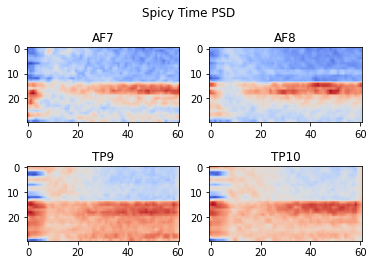

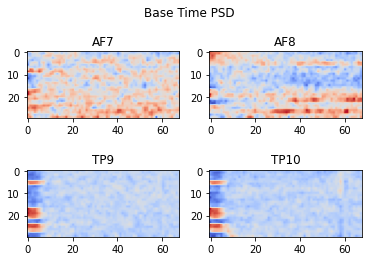

In [9]:
spicy_t_psd = time_psd(data_spicy, freq_spicy, 10, 20)
base_t_psd = time_psd(data_base, freq_base, 10, 20)
plot_time_psd(spicy_t_psd, 'Spicy Time PSD')
plot_time_psd(base_t_psd, 'Base Time PSD')

### Plot sum of power inside each time window

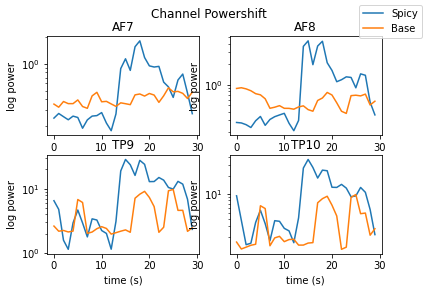

In [10]:
plot_channel_powershift(spicy_t_psd, 'Spicy', False)
plot_channel_powershift(base_t_psd, 'Base')